<a href="https://colab.research.google.com/github/WasifAsi/DSGP_GP-19/blob/deeplabv3%2B/Models/DeepLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imports**

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from PIL import Image
import cv2
from google.colab import drive
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pickle
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import torch.cuda.amp as amp

# Mount Google Drive
drive.mount('/content/drive')

# Create model directory in Google Drive
MODEL_SAVE_PATH = '/content/drive/MyDrive/shoreline_model_final'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set hyperparameters
learning_rate = 0.0003
batch_size = 4  # Reduced for large images
num_epochs = 200
image_size = 1024  # Cropped size

Mounted at /content/drive
Using device: cuda


#**Loss Functions**

In [2]:
# Helper function to ensure group normalization works correctly
def get_groups(channels, target_groups=32):
    # Find the largest divisor of channels that is <= target_groups
    for i in range(target_groups, 0, -1):
        if channels % i == 0:
            return i
    return 1  # Fallback to 1 group (which is always valid)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        # Apply sigmoid
        pred_prob = torch.sigmoid(pred)

        # Calculate pt
        pt = target * pred_prob + (1 - target) * (1 - pred_prob)

        # Calculate focal weight
        focal_weight = (1 - pt) ** self.gamma

        # Calculate loss
        loss = -self.alpha * focal_weight * torch.log(pt + 1e-12)

        return loss.mean()

# Combine with Dice Loss
class CombinedFocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0, dice_weight=0.5):
        super().__init__()
        self.focal = FocalLoss(alpha=alpha, gamma=gamma)
        self.dice_weight = dice_weight

    def forward(self, pred, target):
        focal_loss = self.focal(pred, target)

        pred_prob = torch.sigmoid(pred)
        intersection = (pred_prob * target).sum()
        dice_loss = 1 - (2. * intersection + 1) / (pred_prob.sum() + target.sum() + 1)

        return focal_loss + self.dice_weight * dice_loss


#**Model Components**

In [3]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_gn=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        if use_gn:
            self.norm1 = nn.GroupNorm(get_groups(out_channels), out_channels)
        else:
            self.norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        if use_gn:
            self.norm2 = nn.GroupNorm(get_groups(out_channels), out_channels)
        else:
            self.norm2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            if use_gn:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                    nn.GroupNorm(get_groups(out_channels), out_channels)
                )
            else:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        out = F.relu(self.norm1(self.conv1(x)))
        out = self.norm2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation, use_gn=False):
        if use_gn:
            super().__init__(
                nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
                nn.GroupNorm(get_groups(out_channels), out_channels),
                nn.ReLU()
            )
        else:
            super().__init__(
                nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )

class ASPPPooling(nn.Module):
    def __init__(self, in_channels, out_channels, use_gn=False):
        super().__init__()
        if use_gn:
            self.pooling = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.GroupNorm(get_groups(out_channels), out_channels),
                nn.ReLU()
            )
        else:
            self.pooling = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )

    def forward(self, x):
        size = x.shape[-2:]
        x = self.pooling(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256, use_gn=False):
        super().__init__()
        modules = []
        if use_gn:
            modules.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.GroupNorm(get_groups(out_channels), out_channels),
                nn.ReLU()))
        else:
            modules.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()))

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate, use_gn))

        modules.append(ASPPPooling(in_channels, out_channels, use_gn))

        self.convs = nn.ModuleList(modules)

        if use_gn:
            self.project = nn.Sequential(
                nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
                nn.GroupNorm(get_groups(out_channels), out_channels),
                nn.ReLU(),
                nn.Dropout(0.5))
        else:
            self.project = nn.Sequential(
                nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

#**Main Model**

In [4]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=1, use_gn=True):
        super().__init__()

        # Initial conv layers with reduced stride
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Using stride=2 to reduce memory
        if use_gn:
            self.norm1 = nn.GroupNorm(get_groups(64), 64)
        else:
            self.norm1 = nn.BatchNorm2d(64)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Reduce memory with stride=2

        # ResNet-like blocks with modified strides for memory efficiency
        self.layer1 = self._make_layer(64, 64, 3, stride=1, use_gn=use_gn)
        self.layer2 = self._make_layer(64, 128, 4, stride=2, use_gn=use_gn)
        self.layer3 = self._make_layer(128, 256, 6, stride=2, use_gn=use_gn)
        self.layer4 = self._make_layer(256, 512, 3, stride=1, use_gn=use_gn)

        # Memory-efficient ASPP
        self.aspp = ASPP(512, [3, 6, 9], use_gn=use_gn)  # Reduced dilation rates

        # Low-level features conversion
        if use_gn:
            self.low_level_conv = nn.Sequential(
                nn.Conv2d(64, 48, 1, bias=False),
                nn.GroupNorm(get_groups(48), 48),
                nn.ReLU()
            )
        else:
            self.low_level_conv = nn.Sequential(
                nn.Conv2d(64, 48, 1, bias=False),
                nn.BatchNorm2d(48),
                nn.ReLU()
            )

        # Auxiliary decoder
        if use_gn:
            self.aux_decoder = nn.Sequential(
                nn.Conv2d(512, 256, 3, padding=1),
                nn.GroupNorm(get_groups(256), 256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Conv2d(256, 1, 1)
            )
        else:
            self.aux_decoder = nn.Sequential(
                nn.Conv2d(512, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Conv2d(256, 1, 1)
            )

        # Main decoder
        if use_gn:
            self.decoder = nn.Sequential(
                nn.Conv2d(304, 256, 3, padding=1, bias=False),
                nn.GroupNorm(get_groups(256), 256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Conv2d(256, 256, 3, padding=1, bias=False),
                nn.GroupNorm(get_groups(256), 256),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Conv2d(256, num_classes, 1)
            )
        else:
            self.decoder = nn.Sequential(
                nn.Conv2d(304, 256, 3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Conv2d(256, 256, 3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Conv2d(256, num_classes, 1)
            )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride, use_gn=False):
        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride, use_gn=use_gn))
        for _ in range(1, num_blocks):
            layers.append(ResBlock(out_channels, out_channels, use_gn=use_gn))
        return nn.Sequential(*layers)

    def forward(self, x):
        input_size = x.size()[-2:]

        # Initial convolutions
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.maxpool(x)

        # Backbone
        low_level_feat = self.layer1(x)
        x = self.layer2(low_level_feat)
        x = self.layer3(x)
        x = self.layer4(x)

        # Auxiliary output
        aux_out = self.aux_decoder(x)
        aux_out = F.interpolate(aux_out, size=input_size, mode='bilinear', align_corners=False)

        # ASPP
        x = self.aspp(x)

        # Decoder
        x = F.interpolate(x, size=low_level_feat.shape[2:], mode='bilinear', align_corners=False)
        low_level_feat = self.low_level_conv(low_level_feat)
        x = torch.cat([x, low_level_feat], dim=1)
        x = self.decoder(x)

        # Final upsampling
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

        if self.training:
            return x, aux_out
        return x

#**Dataset and transform**

In [5]:
class ShorelineDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 128).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

#**Early stopping**

In [6]:
class EarlyStopping:
    def __init__(self, patience=45, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

#**Dataset Transform and Loader function**

In [7]:
def get_preprocessing_transform(image_size=1024):
    return A.Compose([
        A.CenterCrop(height=image_size, width=image_size),  # Center crop to square
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

def get_training_transform(image_size=1024):
    return A.Compose([
        A.CenterCrop(height=image_size, width=image_size),  # Center crop to square
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, p=0.5),
        ], p=0.3),
        A.OneOf([
            A.GaussianBlur(blur_limit=3, p=0.5),
            A.MedianBlur(blur_limit=3, p=0.5),
            A.MotionBlur(blur_limit=3, p=0.5),
        ], p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.HueSaturationValue(p=0.5),
        ], p=0.3),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

def prepare_dataloaders(train_image_dir, train_mask_dir,
                     val_image_dir, val_mask_dir,
                     test_image_dir, test_mask_dir,
                     batch_size=1, image_size=1024):
    """
    Prepare dataloaders using the specified directory structure with memory optimizations
    """
    # Create datasets
    train_dataset = ShorelineDataset(
        train_image_dir,
        train_mask_dir,
        transform=get_training_transform(image_size)
    )

    val_dataset = ShorelineDataset(
        val_image_dir,
        val_mask_dir,
        transform=get_preprocessing_transform(image_size)
    )

    test_dataset = ShorelineDataset(
        test_image_dir,
        test_mask_dir,
        transform=get_preprocessing_transform(image_size)
    )

    # Create memory-optimized dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )

    return train_loader, val_loader, test_loader

#**Training function**

In [8]:
def train_model(model, train_loader, val_loader, device, num_epochs=200, learning_rate=5e-4):
    # Initialize loss function and optimizer
    criterion = CombinedFocalDiceLoss(alpha=0.8, gamma=2.0, dice_weight=0.5)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    early_stopping = EarlyStopping(patience=45, min_delta=1e-4)

    # Initialize mixed precision scaler for memory efficiency
    scaler = amp.GradScaler()

    best_loss = float('inf')
    training_data = {
        "loss": [],
        "epoch": [],
        "lr": [],
        "val_loss": []
    }

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            masks = masks.float().to(device)

            # Empty cache between batches
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            optimizer.zero_grad()

            # Use mixed precision for forward pass
            with amp.autocast():
                main_outputs, aux_outputs = model(images)
                main_loss = criterion(main_outputs, masks.unsqueeze(1))
                aux_loss = criterion(aux_outputs, masks.unsqueeze(1))
                loss = main_loss + 0.4 * aux_loss

            # Scale gradients and perform backward pass
            scaler.scale(loss).backward()

            # Gradient clipping with scaled gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update parameters with scaled optimizer
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        # Validation with memory optimization
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.float().to(device)

                # Empty cache between batches
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

                # Use mixed precision during validation too
                with amp.autocast():
                    outputs = model(images)
                    val_loss += criterion(outputs, masks.unsqueeze(1)).item()

        epoch_loss = total_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {epoch_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        scheduler.step()

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'best_shoreline_deeplabv3.pt'))

        # Early stopping check
        if early_stopping(val_loss):
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

        # Update training data
        training_data["loss"].append(epoch_loss)
        training_data["epoch"].append(epoch)
        training_data["lr"].append(optimizer.param_groups[0]['lr'])
        training_data["val_loss"].append(val_loss)

        # Save training history periodically
        if epoch % 5 == 0:
            with open(os.path.join(MODEL_SAVE_PATH, 'training_history_deeplabv3.pkl'), 'wb') as f:
                pickle.dump(training_data, f)

        # Clear memory after each epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Save final model and training history
    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'final_shoreline_deeplabv3.pt'))
    with open(os.path.join(MODEL_SAVE_PATH, 'final_training_history_deeplabv3.pkl'), 'wb') as f:
        pickle.dump(training_data, f)

    return model, training_data

#**Main function**

In [ ]:
def main():
    # Set paths for your directory structure
    train_image_dir = '/content/drive/MyDrive/dataset/training_satellite'
    train_mask_dir = '/content/drive/MyDrive/dataset/training_mask'
    val_image_dir = '/content/drive/MyDrive/dataset/validation_satellite'
    val_mask_dir = '/content/drive/MyDrive/dataset/validation_mask'
    test_image_dir = '/content/drive/MyDrive/dataset/testing_satellite'
    test_mask_dir = '/content/drive/MyDrive/dataset/testing_mask'

    # Prepare dataloaders
    train_loader, val_loader, test_loader = prepare_dataloaders(
        train_image_dir=train_image_dir,
        train_mask_dir=train_mask_dir,
        val_image_dir=val_image_dir,
        val_mask_dir=val_mask_dir,
        test_image_dir=test_image_dir,
        test_mask_dir=test_mask_dir,
        batch_size=batch_size,
        image_size=image_size
    )

    # Initialize model with GroupNorm for better memory efficiency
    model = DeepLabV3Plus(num_classes=1, use_gn=True).to(device)

    # Train model
    print("Starting training...")
    trained_model, training_history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        num_epochs=num_epochs,
        learning_rate=learning_rate
    )
if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-8-3df7a645b121>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Starting training...


Epoch 1/200:   0%|          | 0/128 [00:00<?, ?it/s]<ipython-input-8-3df7a645b121>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1/200: 100%|██████████| 128/128 [02:30<00:00,  1.18s/it]
<ipython-input-8-3df7a645b121>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 1/200
Training Loss: 0.5521
Validation Loss: 0.2848
Learning Rate: 0.000300


Epoch 2/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 2/200
Training Loss: 0.3843
Validation Loss: 0.2563
Learning Rate: 0.000300


Epoch 3/200: 100%|██████████| 128/128 [00:22<00:00,  5.76it/s]


Epoch 3/200
Training Loss: 0.3423
Validation Loss: 0.2066
Learning Rate: 0.000300


Epoch 4/200: 100%|██████████| 128/128 [00:22<00:00,  5.68it/s]


Epoch 4/200
Training Loss: 0.3251
Validation Loss: 0.2088
Learning Rate: 0.000300


Epoch 5/200: 100%|██████████| 128/128 [00:22<00:00,  5.76it/s]


Epoch 5/200
Training Loss: 0.3177
Validation Loss: 0.1963
Learning Rate: 0.000300


Epoch 6/200: 100%|██████████| 128/128 [00:22<00:00,  5.82it/s]


Epoch 6/200
Training Loss: 0.3110
Validation Loss: 0.1994
Learning Rate: 0.000300


Epoch 7/200: 100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 7/200
Training Loss: 0.3014
Validation Loss: 0.1949
Learning Rate: 0.000299


Epoch 8/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 8/200
Training Loss: 0.3029
Validation Loss: 0.1868
Learning Rate: 0.000299


Epoch 9/200: 100%|██████████| 128/128 [00:22<00:00,  5.78it/s]


Epoch 9/200
Training Loss: 0.2932
Validation Loss: 0.1852
Learning Rate: 0.000299


Epoch 10/200: 100%|██████████| 128/128 [00:22<00:00,  5.78it/s]


Epoch 10/200
Training Loss: 0.2939
Validation Loss: 0.1869
Learning Rate: 0.000299


Epoch 11/200: 100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 11/200
Training Loss: 0.2897
Validation Loss: 0.1808
Learning Rate: 0.000298


Epoch 12/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 12/200
Training Loss: 0.2920
Validation Loss: 0.1866
Learning Rate: 0.000298


Epoch 13/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 13/200
Training Loss: 0.2862
Validation Loss: 0.1784
Learning Rate: 0.000297


Epoch 14/200: 100%|██████████| 128/128 [00:22<00:00,  5.70it/s]


Epoch 14/200
Training Loss: 0.2850
Validation Loss: 0.1746
Learning Rate: 0.000297


Epoch 15/200: 100%|██████████| 128/128 [00:22<00:00,  5.69it/s]


Epoch 15/200
Training Loss: 0.2829
Validation Loss: 0.1720
Learning Rate: 0.000296


Epoch 16/200: 100%|██████████| 128/128 [00:22<00:00,  5.70it/s]


Epoch 16/200
Training Loss: 0.2809
Validation Loss: 0.1753
Learning Rate: 0.000296


Epoch 17/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 17/200
Training Loss: 0.2807
Validation Loss: 0.1758
Learning Rate: 0.000295


Epoch 18/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 18/200
Training Loss: 0.2776
Validation Loss: 0.1738
Learning Rate: 0.000295


Epoch 19/200: 100%|██████████| 128/128 [00:22<00:00,  5.80it/s]


Epoch 19/200
Training Loss: 0.2751
Validation Loss: 0.1703
Learning Rate: 0.000294


Epoch 20/200: 100%|██████████| 128/128 [00:22<00:00,  5.75it/s]


Epoch 20/200
Training Loss: 0.2728
Validation Loss: 0.1715
Learning Rate: 0.000293


Epoch 21/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 21/200
Training Loss: 0.2725
Validation Loss: 0.1686
Learning Rate: 0.000293


Epoch 22/200: 100%|██████████| 128/128 [00:22<00:00,  5.79it/s]


Epoch 22/200
Training Loss: 0.2740
Validation Loss: 0.1739
Learning Rate: 0.000292


Epoch 23/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 23/200
Training Loss: 0.2727
Validation Loss: 0.1712
Learning Rate: 0.000291


Epoch 24/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 24/200
Training Loss: 0.2724
Validation Loss: 0.1755
Learning Rate: 0.000290


Epoch 25/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 25/200
Training Loss: 0.2725
Validation Loss: 0.1673
Learning Rate: 0.000290


Epoch 26/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 26/200
Training Loss: 0.2709
Validation Loss: 0.1736
Learning Rate: 0.000289


Epoch 27/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 27/200
Training Loss: 0.2682
Validation Loss: 0.1670
Learning Rate: 0.000288


Epoch 28/200: 100%|██████████| 128/128 [00:22<00:00,  5.78it/s]


Epoch 28/200
Training Loss: 0.2667
Validation Loss: 0.1627
Learning Rate: 0.000287


Epoch 29/200: 100%|██████████| 128/128 [00:22<00:00,  5.77it/s]


Epoch 29/200
Training Loss: 0.2693
Validation Loss: 0.1660
Learning Rate: 0.000286


Epoch 30/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 30/200
Training Loss: 0.2681
Validation Loss: 0.1693
Learning Rate: 0.000285


Epoch 31/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 31/200
Training Loss: 0.2645
Validation Loss: 0.1697
Learning Rate: 0.000284


Epoch 32/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 32/200
Training Loss: 0.2670
Validation Loss: 0.1693
Learning Rate: 0.000283


Epoch 33/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 33/200
Training Loss: 0.2674
Validation Loss: 0.1698
Learning Rate: 0.000282


Epoch 34/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 34/200
Training Loss: 0.2686
Validation Loss: 0.1668
Learning Rate: 0.000280


Epoch 35/200: 100%|██████████| 128/128 [00:22<00:00,  5.81it/s]


Epoch 35/200
Training Loss: 0.2657
Validation Loss: 0.1628
Learning Rate: 0.000279


Epoch 36/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 36/200
Training Loss: 0.2621
Validation Loss: 0.1710
Learning Rate: 0.000278


Epoch 37/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 37/200
Training Loss: 0.2653
Validation Loss: 0.1621
Learning Rate: 0.000277


Epoch 38/200: 100%|██████████| 128/128 [00:22<00:00,  5.75it/s]


Epoch 38/200
Training Loss: 0.2620
Validation Loss: 0.1642
Learning Rate: 0.000275


Epoch 39/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 39/200
Training Loss: 0.2607
Validation Loss: 0.1617
Learning Rate: 0.000274


Epoch 40/200: 100%|██████████| 128/128 [00:22<00:00,  5.73it/s]


Epoch 40/200
Training Loss: 0.2657
Validation Loss: 0.1606
Learning Rate: 0.000273


Epoch 41/200: 100%|██████████| 128/128 [00:22<00:00,  5.75it/s]


Epoch 41/200
Training Loss: 0.2620
Validation Loss: 0.1621
Learning Rate: 0.000271


Epoch 42/200: 100%|██████████| 128/128 [00:22<00:00,  5.70it/s]


Epoch 42/200
Training Loss: 0.2620
Validation Loss: 0.1600
Learning Rate: 0.000270


Epoch 43/200: 100%|██████████| 128/128 [00:22<00:00,  5.76it/s]


Epoch 43/200
Training Loss: 0.2595
Validation Loss: 0.1673
Learning Rate: 0.000269


Epoch 44/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 44/200
Training Loss: 0.2599
Validation Loss: 0.1583
Learning Rate: 0.000267


Epoch 45/200: 100%|██████████| 128/128 [00:22<00:00,  5.76it/s]


Epoch 45/200
Training Loss: 0.2618
Validation Loss: 0.1574
Learning Rate: 0.000266


Epoch 46/200: 100%|██████████| 128/128 [00:22<00:00,  5.73it/s]


Epoch 46/200
Training Loss: 0.2572
Validation Loss: 0.1609
Learning Rate: 0.000264


Epoch 47/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 47/200
Training Loss: 0.2616
Validation Loss: 0.1605
Learning Rate: 0.000263


Epoch 48/200: 100%|██████████| 128/128 [00:22<00:00,  5.82it/s]


Epoch 48/200
Training Loss: 0.2589
Validation Loss: 0.1706
Learning Rate: 0.000261


Epoch 49/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 49/200
Training Loss: 0.2575
Validation Loss: 0.1584
Learning Rate: 0.000259


Epoch 50/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 50/200
Training Loss: 0.2561
Validation Loss: 0.1594
Learning Rate: 0.000258


Epoch 51/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 51/200
Training Loss: 0.2581
Validation Loss: 0.1561
Learning Rate: 0.000256


Epoch 52/200: 100%|██████████| 128/128 [00:22<00:00,  5.74it/s]


Epoch 52/200
Training Loss: 0.2566
Validation Loss: 0.1554
Learning Rate: 0.000255


Epoch 53/200: 100%|██████████| 128/128 [00:22<00:00,  5.78it/s]


Epoch 53/200
Training Loss: 0.2526
Validation Loss: 0.1562
Learning Rate: 0.000253


Epoch 54/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 54/200
Training Loss: 0.2590
Validation Loss: 0.1564
Learning Rate: 0.000251


Epoch 55/200: 100%|██████████| 128/128 [00:22<00:00,  5.81it/s]


Epoch 55/200
Training Loss: 0.2537
Validation Loss: 0.1585
Learning Rate: 0.000249


Epoch 56/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 56/200
Training Loss: 0.2562
Validation Loss: 0.1583
Learning Rate: 0.000248


Epoch 57/200: 100%|██████████| 128/128 [00:22<00:00,  5.81it/s]


Epoch 57/200
Training Loss: 0.2541
Validation Loss: 0.1543
Learning Rate: 0.000246


Epoch 58/200: 100%|██████████| 128/128 [00:21<00:00,  5.82it/s]


Epoch 58/200
Training Loss: 0.2539
Validation Loss: 0.1544
Learning Rate: 0.000244


Epoch 59/200: 100%|██████████| 128/128 [00:22<00:00,  5.79it/s]


Epoch 59/200
Training Loss: 0.2537
Validation Loss: 0.1541
Learning Rate: 0.000242


Epoch 60/200: 100%|██████████| 128/128 [00:22<00:00,  5.71it/s]


Epoch 60/200
Training Loss: 0.2535
Validation Loss: 0.1546
Learning Rate: 0.000240


Epoch 61/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 61/200
Training Loss: 0.2574
Validation Loss: 0.1530
Learning Rate: 0.000238


Epoch 62/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 62/200
Training Loss: 0.2548
Validation Loss: 0.1529
Learning Rate: 0.000236


Epoch 63/200: 100%|██████████| 128/128 [00:22<00:00,  5.76it/s]


Epoch 63/200
Training Loss: 0.2530
Validation Loss: 0.1555
Learning Rate: 0.000235


Epoch 64/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 64/200
Training Loss: 0.2511
Validation Loss: 0.1547
Learning Rate: 0.000233


Epoch 65/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 65/200
Training Loss: 0.2517
Validation Loss: 0.1517
Learning Rate: 0.000231


Epoch 66/200: 100%|██████████| 128/128 [00:22<00:00,  5.68it/s]


Epoch 66/200
Training Loss: 0.2506
Validation Loss: 0.1525
Learning Rate: 0.000229


Epoch 67/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 67/200
Training Loss: 0.2486
Validation Loss: 0.1540
Learning Rate: 0.000227


Epoch 68/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 68/200
Training Loss: 0.2513
Validation Loss: 0.1512
Learning Rate: 0.000225


Epoch 69/200: 100%|██████████| 128/128 [00:22<00:00,  5.70it/s]


Epoch 69/200
Training Loss: 0.2527
Validation Loss: 0.1538
Learning Rate: 0.000223


Epoch 70/200: 100%|██████████| 128/128 [00:22<00:00,  5.72it/s]


Epoch 70/200
Training Loss: 0.2523
Validation Loss: 0.1529
Learning Rate: 0.000220


Epoch 71/200: 100%|██████████| 128/128 [00:22<00:00,  5.80it/s]


Epoch 71/200
Training Loss: 0.2528
Validation Loss: 0.1566
Learning Rate: 0.000218


Epoch 72/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 72/200
Training Loss: 0.2484
Validation Loss: 0.1561
Learning Rate: 0.000216


Epoch 73/200: 100%|██████████| 128/128 [00:22<00:00,  5.82it/s]


Epoch 73/200
Training Loss: 0.2506
Validation Loss: 0.1530
Learning Rate: 0.000214


Epoch 74/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 74/200
Training Loss: 0.2490
Validation Loss: 0.1535
Learning Rate: 0.000212


Epoch 75/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 75/200
Training Loss: 0.2484
Validation Loss: 0.1504
Learning Rate: 0.000210


Epoch 76/200: 100%|██████████| 128/128 [00:22<00:00,  5.75it/s]


Epoch 76/200
Training Loss: 0.2502
Validation Loss: 0.1550
Learning Rate: 0.000208


Epoch 77/200: 100%|██████████| 128/128 [00:22<00:00,  5.75it/s]


Epoch 77/200
Training Loss: 0.2521
Validation Loss: 0.1528
Learning Rate: 0.000206


Epoch 78/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 78/200
Training Loss: 0.2509
Validation Loss: 0.1543
Learning Rate: 0.000203


Epoch 79/200: 100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 79/200
Training Loss: 0.2485
Validation Loss: 0.1518
Learning Rate: 0.000201


Epoch 80/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 80/200
Training Loss: 0.2512
Validation Loss: 0.1524
Learning Rate: 0.000199


Epoch 81/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 81/200
Training Loss: 0.2488
Validation Loss: 0.1509
Learning Rate: 0.000197


Epoch 82/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 82/200
Training Loss: 0.2457
Validation Loss: 0.1512
Learning Rate: 0.000194


Epoch 83/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 83/200
Training Loss: 0.2472
Validation Loss: 0.1522
Learning Rate: 0.000192


Epoch 84/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 84/200
Training Loss: 0.2481
Validation Loss: 0.1518
Learning Rate: 0.000190


Epoch 85/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 85/200
Training Loss: 0.2482
Validation Loss: 0.1522
Learning Rate: 0.000188


Epoch 86/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 86/200
Training Loss: 0.2477
Validation Loss: 0.1515
Learning Rate: 0.000185


Epoch 87/200: 100%|██████████| 128/128 [00:22<00:00,  5.81it/s]


Epoch 87/200
Training Loss: 0.2487
Validation Loss: 0.1514
Learning Rate: 0.000183


Epoch 88/200: 100%|██████████| 128/128 [00:22<00:00,  5.81it/s]


Epoch 88/200
Training Loss: 0.2449
Validation Loss: 0.1520
Learning Rate: 0.000181


Epoch 89/200: 100%|██████████| 128/128 [00:21<00:00,  5.82it/s]


Epoch 89/200
Training Loss: 0.2452
Validation Loss: 0.1484
Learning Rate: 0.000179


Epoch 90/200: 100%|██████████| 128/128 [00:22<00:00,  5.80it/s]


Epoch 90/200
Training Loss: 0.2455
Validation Loss: 0.1499
Learning Rate: 0.000176


Epoch 91/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 91/200
Training Loss: 0.2444
Validation Loss: 0.1492
Learning Rate: 0.000174


Epoch 92/200: 100%|██████████| 128/128 [00:21<00:00,  5.82it/s]


Epoch 92/200
Training Loss: 0.2474
Validation Loss: 0.1502
Learning Rate: 0.000172


Epoch 93/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 93/200
Training Loss: 0.2457
Validation Loss: 0.1497
Learning Rate: 0.000169


Epoch 94/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 94/200
Training Loss: 0.2457
Validation Loss: 0.1517
Learning Rate: 0.000167


Epoch 95/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 95/200
Training Loss: 0.2444
Validation Loss: 0.1499
Learning Rate: 0.000165


Epoch 96/200: 100%|██████████| 128/128 [00:21<00:00,  5.82it/s]


Epoch 96/200
Training Loss: 0.2430
Validation Loss: 0.1478
Learning Rate: 0.000162


Epoch 97/200: 100%|██████████| 128/128 [00:22<00:00,  5.72it/s]


Epoch 97/200
Training Loss: 0.2456
Validation Loss: 0.1486
Learning Rate: 0.000160


Epoch 98/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 98/200
Training Loss: 0.2463
Validation Loss: 0.1534
Learning Rate: 0.000158


Epoch 99/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 99/200
Training Loss: 0.2455
Validation Loss: 0.1493
Learning Rate: 0.000155


Epoch 100/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 100/200
Training Loss: 0.2416
Validation Loss: 0.1484
Learning Rate: 0.000153


Epoch 101/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 101/200
Training Loss: 0.2448
Validation Loss: 0.1488
Learning Rate: 0.000150


Epoch 102/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 102/200
Training Loss: 0.2425
Validation Loss: 0.1483
Learning Rate: 0.000148


Epoch 103/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 103/200
Training Loss: 0.2438
Validation Loss: 0.1484
Learning Rate: 0.000146


Epoch 104/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 104/200
Training Loss: 0.2452
Validation Loss: 0.1478
Learning Rate: 0.000143


Epoch 105/200: 100%|██████████| 128/128 [00:22<00:00,  5.80it/s]


Epoch 105/200
Training Loss: 0.2428
Validation Loss: 0.1485
Learning Rate: 0.000141


Epoch 106/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 106/200
Training Loss: 0.2419
Validation Loss: 0.1484
Learning Rate: 0.000139


Epoch 107/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 107/200
Training Loss: 0.2414
Validation Loss: 0.1497
Learning Rate: 0.000136


Epoch 108/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 108/200
Training Loss: 0.2422
Validation Loss: 0.1476
Learning Rate: 0.000134


Epoch 109/200: 100%|██████████| 128/128 [00:22<00:00,  5.73it/s]


Epoch 109/200
Training Loss: 0.2413
Validation Loss: 0.1484
Learning Rate: 0.000132


Epoch 110/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 110/200
Training Loss: 0.2424
Validation Loss: 0.1501
Learning Rate: 0.000129


Epoch 111/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 111/200
Training Loss: 0.2408
Validation Loss: 0.1477
Learning Rate: 0.000127


Epoch 112/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 112/200
Training Loss: 0.2423
Validation Loss: 0.1468
Learning Rate: 0.000125


Epoch 113/200: 100%|██████████| 128/128 [00:22<00:00,  5.63it/s]


Epoch 113/200
Training Loss: 0.2419
Validation Loss: 0.1461
Learning Rate: 0.000122


Epoch 114/200: 100%|██████████| 128/128 [00:22<00:00,  5.65it/s]


Epoch 114/200
Training Loss: 0.2424
Validation Loss: 0.1495
Learning Rate: 0.000120


Epoch 115/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 115/200
Training Loss: 0.2431
Validation Loss: 0.1480
Learning Rate: 0.000118


Epoch 116/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 116/200
Training Loss: 0.2431
Validation Loss: 0.1469
Learning Rate: 0.000116


Epoch 117/200: 100%|██████████| 128/128 [00:21<00:00,  5.92it/s]


Epoch 117/200
Training Loss: 0.2421
Validation Loss: 0.1502
Learning Rate: 0.000113


Epoch 118/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 118/200
Training Loss: 0.2398
Validation Loss: 0.1465
Learning Rate: 0.000111


Epoch 119/200: 100%|██████████| 128/128 [00:22<00:00,  5.79it/s]


Epoch 119/200
Training Loss: 0.2399
Validation Loss: 0.1467
Learning Rate: 0.000109


Epoch 120/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 120/200
Training Loss: 0.2382
Validation Loss: 0.1464
Learning Rate: 0.000107


Epoch 121/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 121/200
Training Loss: 0.2388
Validation Loss: 0.1472
Learning Rate: 0.000104


Epoch 122/200: 100%|██████████| 128/128 [00:22<00:00,  5.80it/s]


Epoch 122/200
Training Loss: 0.2395
Validation Loss: 0.1478
Learning Rate: 0.000102


Epoch 123/200: 100%|██████████| 128/128 [00:22<00:00,  5.78it/s]


Epoch 123/200
Training Loss: 0.2398
Validation Loss: 0.1468
Learning Rate: 0.000100


Epoch 124/200: 100%|██████████| 128/128 [00:22<00:00,  5.77it/s]


Epoch 124/200
Training Loss: 0.2379
Validation Loss: 0.1453
Learning Rate: 0.000098


Epoch 125/200: 100%|██████████| 128/128 [00:22<00:00,  5.77it/s]


Epoch 125/200
Training Loss: 0.2385
Validation Loss: 0.1478
Learning Rate: 0.000095


Epoch 126/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 126/200
Training Loss: 0.2396
Validation Loss: 0.1453
Learning Rate: 0.000093


Epoch 127/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 127/200
Training Loss: 0.2383
Validation Loss: 0.1454
Learning Rate: 0.000091


Epoch 128/200: 100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 128/200
Training Loss: 0.2385
Validation Loss: 0.1459
Learning Rate: 0.000089


Epoch 129/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 129/200
Training Loss: 0.2387
Validation Loss: 0.1465
Learning Rate: 0.000087


Epoch 130/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 130/200
Training Loss: 0.2386
Validation Loss: 0.1465
Learning Rate: 0.000085


Epoch 131/200: 100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 131/200
Training Loss: 0.2391
Validation Loss: 0.1467
Learning Rate: 0.000083


Epoch 132/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 132/200
Training Loss: 0.2373
Validation Loss: 0.1456
Learning Rate: 0.000081


Epoch 133/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 133/200
Training Loss: 0.2382
Validation Loss: 0.1478
Learning Rate: 0.000078


Epoch 134/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 134/200
Training Loss: 0.2377
Validation Loss: 0.1453
Learning Rate: 0.000076


Epoch 135/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 135/200
Training Loss: 0.2374
Validation Loss: 0.1453
Learning Rate: 0.000074


Epoch 136/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 136/200
Training Loss: 0.2364
Validation Loss: 0.1469
Learning Rate: 0.000072


Epoch 137/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 137/200
Training Loss: 0.2378
Validation Loss: 0.1454
Learning Rate: 0.000070


Epoch 138/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 138/200
Training Loss: 0.2359
Validation Loss: 0.1452
Learning Rate: 0.000068


Epoch 139/200: 100%|██████████| 128/128 [00:22<00:00,  5.73it/s]


Epoch 139/200
Training Loss: 0.2365
Validation Loss: 0.1452
Learning Rate: 0.000066


Epoch 140/200: 100%|██████████| 128/128 [00:22<00:00,  5.74it/s]


Epoch 140/200
Training Loss: 0.2360
Validation Loss: 0.1461
Learning Rate: 0.000065


Epoch 141/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 141/200
Training Loss: 0.2363
Validation Loss: 0.1466
Learning Rate: 0.000063


Epoch 142/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 142/200
Training Loss: 0.2348
Validation Loss: 0.1456
Learning Rate: 0.000061


Epoch 143/200: 100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 143/200
Training Loss: 0.2348
Validation Loss: 0.1452
Learning Rate: 0.000059


Epoch 144/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 144/200
Training Loss: 0.2346
Validation Loss: 0.1457
Learning Rate: 0.000057


Epoch 145/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 145/200
Training Loss: 0.2368
Validation Loss: 0.1451
Learning Rate: 0.000055


Epoch 146/200: 100%|██████████| 128/128 [00:22<00:00,  5.72it/s]


Epoch 146/200
Training Loss: 0.2346
Validation Loss: 0.1447
Learning Rate: 0.000053


Epoch 147/200: 100%|██████████| 128/128 [00:22<00:00,  5.76it/s]


Epoch 147/200
Training Loss: 0.2335
Validation Loss: 0.1455
Learning Rate: 0.000052


Epoch 148/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 148/200
Training Loss: 0.2344
Validation Loss: 0.1453
Learning Rate: 0.000050


Epoch 149/200: 100%|██████████| 128/128 [00:21<00:00,  5.82it/s]


Epoch 149/200
Training Loss: 0.2333
Validation Loss: 0.1464
Learning Rate: 0.000048


Epoch 150/200: 100%|██████████| 128/128 [00:21<00:00,  5.82it/s]


Epoch 150/200
Training Loss: 0.2345
Validation Loss: 0.1458
Learning Rate: 0.000046


Epoch 151/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 151/200
Training Loss: 0.2342
Validation Loss: 0.1461
Learning Rate: 0.000045


Epoch 152/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 152/200
Training Loss: 0.2334
Validation Loss: 0.1458
Learning Rate: 0.000043


Epoch 153/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 153/200
Training Loss: 0.2320
Validation Loss: 0.1452
Learning Rate: 0.000042


Epoch 154/200: 100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 154/200
Training Loss: 0.2338
Validation Loss: 0.1472
Learning Rate: 0.000040


Epoch 155/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 155/200
Training Loss: 0.2353
Validation Loss: 0.1447
Learning Rate: 0.000038


Epoch 156/200: 100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 156/200
Training Loss: 0.2342
Validation Loss: 0.1446
Learning Rate: 0.000037


Epoch 157/200: 100%|██████████| 128/128 [00:21<00:00,  5.82it/s]


Epoch 157/200
Training Loss: 0.2334
Validation Loss: 0.1455
Learning Rate: 0.000035


Epoch 158/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 158/200
Training Loss: 0.2360
Validation Loss: 0.1449
Learning Rate: 0.000034


Epoch 159/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 159/200
Training Loss: 0.2357
Validation Loss: 0.1457
Learning Rate: 0.000032


Epoch 160/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 160/200
Training Loss: 0.2331
Validation Loss: 0.1453
Learning Rate: 0.000031


Epoch 161/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 161/200
Training Loss: 0.2323
Validation Loss: 0.1447
Learning Rate: 0.000030


Epoch 162/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 162/200
Training Loss: 0.2324
Validation Loss: 0.1448
Learning Rate: 0.000028


Epoch 163/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 163/200
Training Loss: 0.2311
Validation Loss: 0.1445
Learning Rate: 0.000027


Epoch 164/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 164/200
Training Loss: 0.2322
Validation Loss: 0.1448
Learning Rate: 0.000026


Epoch 165/200: 100%|██████████| 128/128 [00:22<00:00,  5.81it/s]


Epoch 165/200
Training Loss: 0.2332
Validation Loss: 0.1454
Learning Rate: 0.000024


Epoch 166/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 166/200
Training Loss: 0.2337
Validation Loss: 0.1458
Learning Rate: 0.000023


Epoch 167/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 167/200
Training Loss: 0.2326
Validation Loss: 0.1449
Learning Rate: 0.000022


Epoch 168/200: 100%|██████████| 128/128 [00:22<00:00,  5.82it/s]


Epoch 168/200
Training Loss: 0.2327
Validation Loss: 0.1453
Learning Rate: 0.000021


Epoch 169/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 169/200
Training Loss: 0.2311
Validation Loss: 0.1450
Learning Rate: 0.000019


Epoch 170/200: 100%|██████████| 128/128 [00:21<00:00,  5.94it/s]


Epoch 170/200
Training Loss: 0.2331
Validation Loss: 0.1453
Learning Rate: 0.000018


Epoch 171/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 171/200
Training Loss: 0.2318
Validation Loss: 0.1449
Learning Rate: 0.000017


Epoch 172/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 172/200
Training Loss: 0.2334
Validation Loss: 0.1453
Learning Rate: 0.000016


Epoch 173/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 173/200
Training Loss: 0.2319
Validation Loss: 0.1451
Learning Rate: 0.000015


Epoch 174/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 174/200
Training Loss: 0.2331
Validation Loss: 0.1443
Learning Rate: 0.000014


Epoch 175/200: 100%|██████████| 128/128 [00:22<00:00,  5.81it/s]


Epoch 175/200
Training Loss: 0.2321
Validation Loss: 0.1452
Learning Rate: 0.000013


Epoch 176/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 176/200
Training Loss: 0.2324
Validation Loss: 0.1445
Learning Rate: 0.000012


Epoch 177/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 177/200
Training Loss: 0.2309
Validation Loss: 0.1447
Learning Rate: 0.000011


Epoch 178/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 178/200
Training Loss: 0.2329
Validation Loss: 0.1458
Learning Rate: 0.000011


Epoch 179/200: 100%|██████████| 128/128 [00:22<00:00,  5.81it/s]


Epoch 179/200
Training Loss: 0.2314
Validation Loss: 0.1449
Learning Rate: 0.000010


Epoch 180/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 180/200
Training Loss: 0.2305
Validation Loss: 0.1455
Learning Rate: 0.000009


Epoch 181/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 181/200
Training Loss: 0.2298
Validation Loss: 0.1459
Learning Rate: 0.000008


Epoch 182/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 182/200
Training Loss: 0.2308
Validation Loss: 0.1452
Learning Rate: 0.000008


Epoch 183/200: 100%|██████████| 128/128 [00:21<00:00,  5.87it/s]


Epoch 183/200
Training Loss: 0.2293
Validation Loss: 0.1447
Learning Rate: 0.000007


Epoch 184/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 184/200
Training Loss: 0.2320
Validation Loss: 0.1451
Learning Rate: 0.000006


Epoch 185/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 185/200
Training Loss: 0.2317
Validation Loss: 0.1445
Learning Rate: 0.000006


Epoch 186/200: 100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


Epoch 186/200
Training Loss: 0.2311
Validation Loss: 0.1450
Learning Rate: 0.000005


Epoch 187/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 187/200
Training Loss: 0.2312
Validation Loss: 0.1448
Learning Rate: 0.000005


Epoch 188/200: 100%|██████████| 128/128 [00:21<00:00,  5.82it/s]


Epoch 188/200
Training Loss: 0.2315
Validation Loss: 0.1451
Learning Rate: 0.000004


Epoch 189/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 189/200
Training Loss: 0.2313
Validation Loss: 0.1448
Learning Rate: 0.000004


Epoch 190/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 190/200
Training Loss: 0.2308
Validation Loss: 0.1448
Learning Rate: 0.000003


Epoch 191/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 191/200
Training Loss: 0.2327
Validation Loss: 0.1449
Learning Rate: 0.000003


Epoch 192/200: 100%|██████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 192/200
Training Loss: 0.2304
Validation Loss: 0.1449
Learning Rate: 0.000002


Epoch 193/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 193/200
Training Loss: 0.2333
Validation Loss: 0.1450
Learning Rate: 0.000002


Epoch 194/200: 100%|██████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 194/200
Training Loss: 0.2322
Validation Loss: 0.1449
Learning Rate: 0.000002


Epoch 195/200: 100%|██████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 195/200
Training Loss: 0.2308
Validation Loss: 0.1449
Learning Rate: 0.000002


Epoch 196/200: 100%|██████████| 128/128 [00:21<00:00,  5.83it/s]


Epoch 196/200
Training Loss: 0.2307
Validation Loss: 0.1450
Learning Rate: 0.000001


Epoch 197/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 197/200
Training Loss: 0.2302
Validation Loss: 0.1450
Learning Rate: 0.000001


Epoch 198/200: 100%|██████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 198/200
Training Loss: 0.2304
Validation Loss: 0.1450
Learning Rate: 0.000001


Epoch 199/200: 100%|██████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 199/200
Training Loss: 0.2310
Validation Loss: 0.1450
Learning Rate: 0.000001


Epoch 200/200: 100%|██████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 200/200
Training Loss: 0.2309
Validation Loss: 0.1450
Learning Rate: 0.000001


Testing a new image

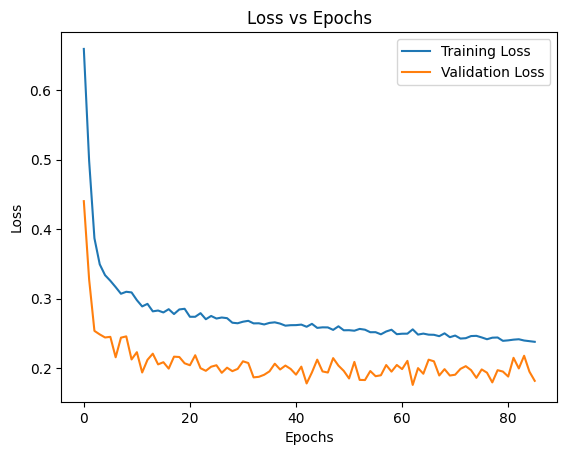

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Step 1: Load the training history from the .pkl file
with open('training_history_deeplabv3.pkl', 'rb') as f:
    history = pickle.load(f)

# Step 2: Extract the loss values (typically stored under 'loss' or 'val_loss')
train_loss = history['loss']  # or history.get('loss') if using a dictionary format
val_loss = history['val_loss']  # if you also want to plot validation loss

# Step 3: Plot the loss graph
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


#**Classification report**

In [ ]:
import os
import torch
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

class ShorelineDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 128).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

def get_preprocessing_transform(image_size=1024):
    return A.Compose([
        A.CenterCrop(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

def evaluate_model(model, test_loader, device, threshold=0.5):
    """Evaluate model and print classification report"""
    model.eval()
    all_preds = []
    all_targets = []

    print("Processing test images...")
    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            if isinstance(outputs, tuple):  # If model returns multiple outputs
                outputs = outputs[0]

            # Apply sigmoid and threshold
            predictions = (torch.sigmoid(outputs) > threshold).float()

            # Add batch predictions and targets to lists
            all_preds.extend(predictions.cpu().numpy().flatten())
            all_targets.extend(masks.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate and print metrics
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds,
                              target_names=['Background', 'Shoreline'],
                              digits=4))

    # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_preds)
    print("\nConfusion Matrix:")
    print("            Predicted")
    print("             0    1")
    print("Actual 0  {:5d} {:5d}".format(conf_matrix[0][0], conf_matrix[0][1]))
    print("       1  {:5d} {:5d}".format(conf_matrix[1][0], conf_matrix[1][1]))

    # Calculate additional metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\nDetailed Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    return {
        'classification_report': classification_report(all_targets, all_preds,
                                                    target_names=['Background', 'Shoreline'],
                                                    digits=4),
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

def main():
    # Set paths
    model_path = '/content/drive/MyDrive/shoreline_model_final/final_shoreline_deeplabv3.pt'
    test_image_dir = '/content/drive/MyDrive/dataset/testing_satellite'  # Directory with test images
    test_mask_dir = '/content/drive/MyDrive/dataset/testing_mask'    # Directory with ground truth masks

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create test dataset and dataloader
    test_transform = get_preprocessing_transform(image_size=1024)
    test_dataset = ShorelineDataset(
        image_dir=test_image_dir,
        mask_dir=test_mask_dir,
        transform=test_transform
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=6,
        shuffle=False,
        num_workers=2
    )

    # Load model
    print("Loading model...")
    model = DeepLabV3Plus(num_classes=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Evaluate model
    print("Starting evaluation...")
    results = evaluate_model(model, test_loader, device)

    # Save results
    save_dir = '/content/drive/MyDrive/shore'
    os.makedirs(save_dir, exist_ok=True)



if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Loading model...
Starting evaluation...
Processing test images...


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]



Classification Report:
              precision    recall  f1-score   support

  Background     0.9991    0.9981    0.9986  58413857
   Shoreline     0.6970    0.8249    0.7556    306399

    accuracy                         0.9972  58720256
   macro avg     0.8481    0.9115    0.8771  58720256
weighted avg     0.9975    0.9972    0.9973  58720256


Confusion Matrix:
            Predicted
             0    1
Actual 0  58304003 109854
       1  53659 252740

Detailed Metrics:
Accuracy: 0.9972
Precision: 0.6970
Recall: 0.8249
F1 Score: 0.7556


In [ ]:
import os
import torch
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

class ShorelineDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, half=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

        if half:
            # Limit dataset to half of the images
            self.images = self.images[:len(self.images)//2]
            self.masks = self.masks[:len(self.masks)//2]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 128).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

def get_preprocessing_transform(image_size=540):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

def evaluate_model(model, test_loader, device, threshold=0.5):
    """Evaluate model and print classification report"""
    model.eval()
    all_preds = []
    all_targets = []

    print("Processing test images...")
    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            if isinstance(outputs, tuple):  # If model returns multiple outputs
                outputs = outputs[0]

            # Apply sigmoid and threshold
            predictions = (torch.sigmoid(outputs) > threshold).float()

            # Add batch predictions and targets to lists
            all_preds.extend(predictions.cpu().numpy().flatten())
            all_targets.extend(masks.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate and print metrics
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds,
                              target_names=['Background', 'Shoreline'],
                              digits=4))

    # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_preds)
    print("\nConfusion Matrix:")
    print("            Predicted")
    print("             0    1")
    print("Actual 0  {:5d} {:5d}".format(conf_matrix[0][0], conf_matrix[0][1]))
    print("       1  {:5d} {:5d}".format(conf_matrix[1][0], conf_matrix[1][1]))

    # Calculate additional metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\nDetailed Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    return {
        'classification_report': classification_report(all_targets, all_preds,
                                                    target_names=['Background', 'Shoreline'],
                                                    digits=4),
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

def main():
    # Set paths
    model_path = '/content/drive/MyDrive/shoreline_models16/best_shoreline_deeplabv3.pt'
    test_image_dir = '/content/drive/MyDrive/data/training_satellite'  # Directory with test images
    test_mask_dir = '/content/drive/MyDrive/data/training_mask'    # Directory with ground truth masks

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create test dataset and dataloader for half of the images
    test_transform = get_preprocessing_transform(image_size=540)
    test_dataset = ShorelineDataset(
        image_dir=test_image_dir,
        mask_dir=test_mask_dir,
        transform=test_transform,
        half=False  # Use only half of the dataset
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=6,
        shuffle=False,
        num_workers=2
    )

    # Load model
    print("Loading model...")
    model = DeepLabV3Plus(num_classes=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Evaluate model
    print("Starting evaluation...")
    results = evaluate_model(model, test_loader, device)

    # Save results
    save_dir = '/content/drive/MyDrive/shore'
    os.makedirs(save_dir, exist_ok=True)

    with open(os.path.join(save_dir, 'evaluation_results.txt'), 'w') as f:
        f.write("Model Evaluation Results\n")
        f.write("=======================\n\n")
        f.write("Classification Report:\n")
        f.write(results['classification_report'])
        f.write("\n\nConfusion Matrix:\n")
        f.write(str(results['confusion_matrix']))
        f.write("\n\nDetailed Metrics:\n")
        f.write(f"Accuracy: {results['accuracy']:.4f}\n")
        f.write(f"Precision: {results['precision']:.4f}\n")
        f.write(f"Recall: {results['recall']:.4f}\n")
        f.write(f"F1 Score: {results['f1_score']:.4f}\n")

    print(f"\nResults saved to: {os.path.join(save_dir, 'evaluation_results.txt')}")

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Loading model...
Starting evaluation...
Processing test images...


100%|██████████| 49/49 [02:13<00:00,  2.72s/it]



Classification Report:
              precision    recall  f1-score   support

  Background     0.9993    0.9982    0.9988  85407160
   Shoreline     0.6366    0.8105    0.7131    323240

    accuracy                         0.9975  85730400
   macro avg     0.8179    0.9044    0.8559  85730400
weighted avg     0.9979    0.9975    0.9977  85730400


Confusion Matrix:
            Predicted
             0    1
Actual 0  85257606 149554
       1  61242 261998

Detailed Metrics:
Accuracy: 0.9975
Precision: 0.6366
Recall: 0.8105
F1 Score: 0.7131

Results saved to: /content/drive/MyDrive/shore/evaluation_results.txt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


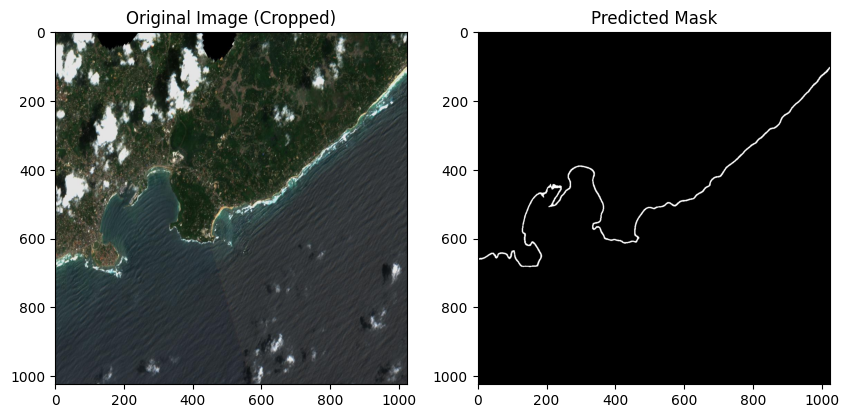

In [10]:
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure you have the DeepLabV3Plus model defined elsewhere
model = DeepLabV3Plus(num_classes=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/best_shoreline_deeplabv3_new.pt", map_location=device))
model.to(device)
model.eval()

# Image Preprocessing with CenterCrop using Albumentations
def preprocess_image(image_path, image_size=1024, crop_size=1024):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = A.Compose([
        A.CenterCrop(height=crop_size, width=crop_size),  # Center crop
        A.Resize(image_size, image_size),  # Resize after cropping
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    augmented = transform(image=image)
    image = augmented["image"].unsqueeze(0)  # Add batch dimension
    return image.to(device), image.shape[1:]  # Return tensor & original shape

# Mask Prediction
def predict_mask(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)  # Convert logits to probabilities
        mask = output.squeeze().cpu().numpy()  # Remove batch & channel dimensions
        return (mask > 0.5).astype(np.uint8)  # Threshold at 0.5

# Display Results
def display_result(image_path, mask, crop_size=1024):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Apply Albumentations CenterCrop
    transform = A.CenterCrop(height=crop_size, width=crop_size)
    original_image_resized = transform(image=original_image)["image"]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image_resized)
    plt.title("Original Image (Cropped)")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Predicted Mask")

    plt.show()

# Run Inference
image_path = "sentinel2_void_2020-11-01_Unawatuna.jpg"  # Update with test image path
image_tensor, _ = preprocess_image(image_path)
predicted_mask = predict_mask(model, image_tensor)
display_result(image_path, predicted_mask)


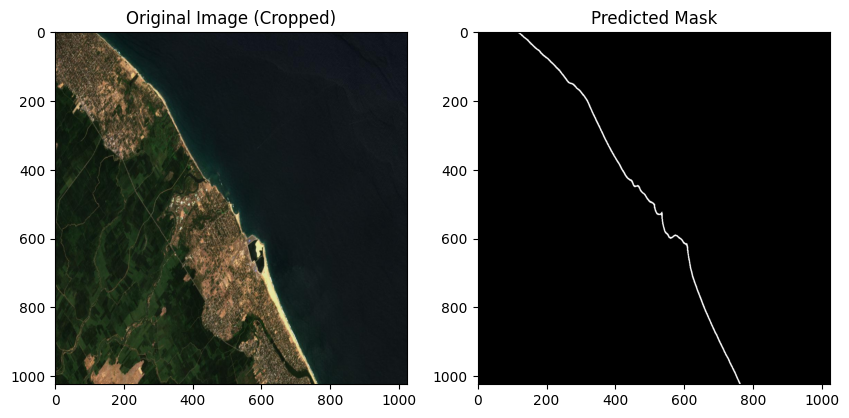

In [11]:
image_path = "sentinel2_void_2019-07-07_Oluvil.jpg"  # Update with test image path
image_tensor, _ = preprocess_image(image_path)
predicted_mask = predict_mask(model, image_tensor)
display_result(image_path, predicted_mask)

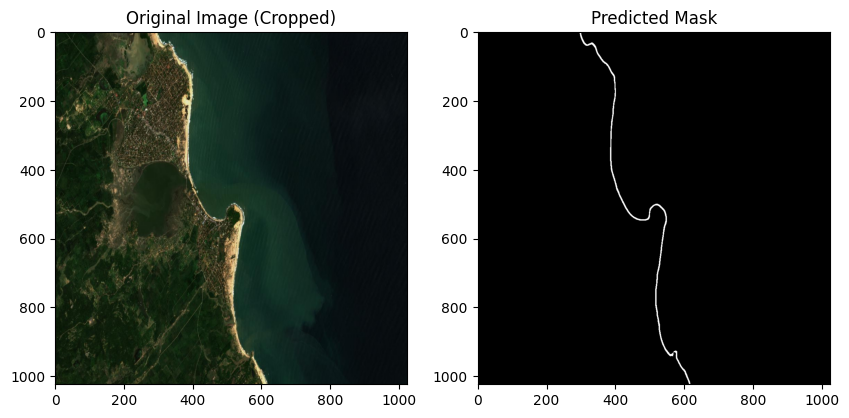

In [12]:
image_path = "sentinel2_void_2018-12-19_ArugamBay.jpg"  # Update with test image path
image_tensor, _ = preprocess_image(image_path)
predicted_mask = predict_mask(model, image_tensor)
display_result(image_path, predicted_mask)